# Description
This notebook is intended to develop and showcase a framework for making neural network architectures which are trained and specialized to different tasks comparable in a unified way. The core problem to be overcome is the multitude of different datasets which might be used to train different networks. I still want to be able to compare the trained network _in a task-independent manner_.

In [80]:
# Imports
import numpy as np 
from numpy import random as rnd 
from matplotlib import pyplot as plt 
import warnings,sys,os,datetime,time,itertools,math 

import pandas as pd 

import torch 
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

# Load full MNIST dataset

In [230]:
D = load_digits()

Xfull,yfull = D['data'],D['target']

Xfull = np.repeat(Xfull,100,0)
yfull = np.repeat(yfull,100,0)

## Visualization of the Data
First take a random sample of the data and visualize it. Take a 9-by-9 grid to plot some numbers.

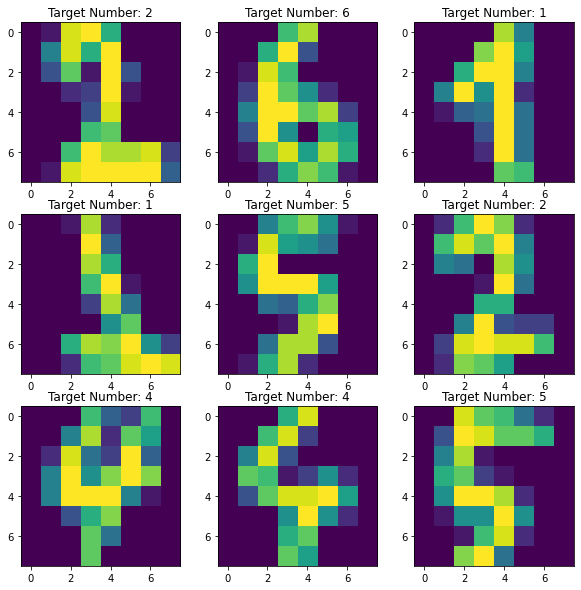

In [231]:
rnd.seed(1)

# Select a random set of indices for visualization
sample_ids = rnd.permutation(np.arange(yfull.shape[0]))[:9]

# Grab the corresponding images and labels
samples = Xfull[sample_ids]
sample_names = yfull[sample_ids]

# Create figure and a 9-by-9 grid of subplots
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10))

# Iterate subplots
ctr = 0
for m in range(3):
    for n in range(3):
        ax[m,n].imshow(samples[ctr].reshape(8,8))
        ax[m,n].set_title('Target Number: {0}'.format(sample_names[ctr]))
        ctr += 1

# Show result
plt.show()

## Generate the training and test sets
This step has to be managed carefully to maintain comparability.

In [232]:
# Train-test split
X,Xtest,y,ytest = train_test_split(Xfull,yfull,test_size=0.25,shuffle=True)

# OneHot-encode the targets
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.reshape(-1,1)).todense()
ytest_ohe = ohe.transform(ytest.reshape(-1,1)).todense()

# Network setup and Training Step
Create a simple CNN to train on the MNIST set. Perform simple training loop.

In [233]:
class Net(nn.Module):
    # Main Function
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,2)
        self.conv2 = nn.Conv2d(6,16,2)
        self.fc1 = nn.Linear(16*2*2,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    # Forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,(1,1))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

In [234]:
# Parameters
batchsize = 3
learning_rate = 1e-2

# Instantiate the network
net = Net()

# Set up the optimizer
optimizer = optim.Adam(net.parameters(),lr=learning_rate)

# Mean Square Loss
loss_fn = nn.MSELoss()

In [235]:
training_losses = []

for idx in range(0,X.shape[0],3):
    # Batch of images
    Xbatch = X[idx:idx+batchsize].reshape(-1,8,8)
    Xbatch_t = torch.from_numpy(Xbatch).reshape(-1,1,8,8).float()
    # Corresponding targets
    Ytarget_t = torch.from_numpy(y_ohe[idx:idx+batchsize]).float()

    # Model output
    Ybatch_t = net.forward(Xbatch_t)

    # Prepare the optimizer
    optimizer.zero_grad()

    # Calculate the loss
    loss = loss_fn(Ybatch_t,Ytarget_t)

    # Propagate the loss
    loss.backward()
    optimizer.step()

    training_losses.append(loss.detach().numpy().flatten()[0])

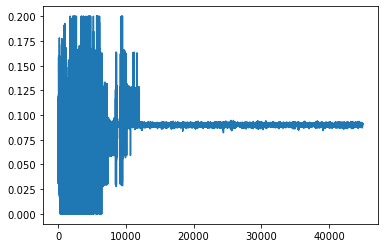

In [236]:
plt.plot(training_losses)